# Tutorial 03: Model Building

*Authors: Zach del Rosario*

---

This is a tutorial on using grama to build a *fully-defined* model. A grama model considers a function and its sources of uncertainty. To carry out [exploratory model analysis](https://github.com/zdelrosario/py_grama/blob/master/tutorials/t02_explore_assignment.ipynb), we need all this information.

**Learning Goals**: By completing this notebook, you will learn:
1. How to fully-define a grama model
1. The importance of *exploratory data analysis* for model building
1. Utility functions in `py_grama` for fitting a distribution
1. Best-practices for building a trustworthy model in a communicable way

**Prerequisites**:
- Familiarity with the Python programming language
- [Tutorial 01: Introduction](https://github.com/zdelrosario/py_grama/blob/master/tutorials/t01_introduction_assignment.ipynb)

**Table of Contents**:
1. [Anatomy of a model](#s1)
1. [Defining a function](#s2)
1. [Defining a distribution](#s3)
   1. [Exploratory data analysis](#s3.1)
   1. [Fitting marginals](#s3.2)
   1. [Fitting a copula](#s3.3)
1. [Evaluating the model](#s4) (Illustration)


## Anatomy of a model <a id="s1"></a>

To remind ourselves of the anatomy of a grama model, we'll first inspect a pre-defined model.

#### __Q1: Initialize grama__
Import grama and the cantilever beam model.

*Hint*: We initialized grama in Tutorial 1, but see if you can remember the appropriate calls.

In [1]:
###
# TASK: Set up grama
# TODO: Import grama, make the cantilever_beam model
###

# task-begin
# TODO: Import grama
# TODO: Assign the cantilever_beam model to `md`
# task-end

# solution-begin
import grama as gr
from grama.models import make_cantilever_beam

# solution-end

# -- NO NEED TO MODIFY BELOW ----
md = make_cantilever_beam()
md.printpretty()

model: Cantilever Beam

  inputs:
    var_det:
      w: [2, 4]
      t: [2, 4]

    var_rand:
      H: (+1) norm, {'loc': 500.0, 'scale': 100.0}
      V: (+1) norm, {'loc': 1000.0, 'scale': 100.0}
      E: (+0) norm, {'loc': 29000000.0, 'scale': 1450000.0}
      Y: (-1) norm, {'loc': 40000.0, 'scale': 2000.0}

    copula:
      Independence copula

  functions:
      cross-sectional area: ['w', 't'] -> ['c_area']
      limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
      limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']



The `printpretty` output above illustrates the necessary elements of a complete grama model:

- The function `inputs`, which include `variables`, which are further are categorized into deterministic (`var_det`) and random (`var_rand`) categories
- Distribution information for the random variables, including marginal distribution shapes (`norm`), their parameters (`loc, scale`), and a dependence structure (`copula`).
- The functions, which map `variables` to `outputs`. 

*General principle*: Since the functions define *which inputs are necessary*, and the distributions define *facts about inputs*, it is generally advisable to start by defining the model functions, then define the distribution. We will follow this suggested order below.

In real grama code, fully-defining a model will look like the following:

```python
md = (
    gr.Model("Model name")
    >> gr.cp_function(
        fun=callable_function,
        var=["x1", "x2", "x3"],
        out=["output1", "output2"],
        name="Human-readable function name"
    )
    >> gr.cp_bounds(
        x1=(-1, +1) # Bounds for deterministic variable
    )
    >> gr.cp_marginals(
        x2=gr.continuous_fit(df_data.x2, "norm") # Fit a normal dist
        x3=gr.continuous_fit(df_data.x3, "beta") # Fit a beta dist
    )
    >> gr.cp_copula_independence() # Specify dependence structure
)
```

After every composition call, we are left with a *valid* grama model. However, the model will only have certain features available at the various stages of (in)completeness. We will walk through building up this model in a *stepwise* fashion.


### Exercise Goal: Buckling Plate Model

---

To accomplish the learning goals of this tutorial, we will build a model for the buckling failure of a metallic plate. 

#### Model purpose

**The most important part of a model is its intended purpose**---this informs all decisions about the model, and serves as our center for assessing model efficacy.

In this exercise, we state the following purpose:

> The purpose of this model is to support the evaluation of an Aluminum plate stock supplier. Our manufacturing process includes forming of the stock with good tolerance control, and the plates are known to be buckling-critical (with free edges) in their intended use-case. The geometry of these plates is fixed and known.

#### Physical model
Since we are ultimately interested in the buckling of plates, we need a physical model for this process. Reference [1] provides a model for the critical buckling stress of a plate with free edges under compressive load. This information is organized into a so-called "limit state function" $g_{\text{buckling}}$ below.

$$g_{\text{buckling}} = \frac{\pi E}{12 (1 - \mu^2)} \left(\frac{t}{h}\right)^2 - \frac{L}{wt}$$

The limit state summarizes information about a structure in terms of *failure*; it takes values corresponding to:

| | |
|-|-|
| $g > 0$ | Safe |
| $g \leq 0$ | Failure |

The inputs for this function are disambiguated in the table below:

| Variable | Symbol | Units |
|---|---|---
| Thickness | $t$ | in |
| Height | $h$ | in |
| Width | $w$ | in |
| Elastic modulus | $E$ | kips / sq-in |
| Poisson ratio | $\mu$ | - |
| Applied load | $L$ | kips |

## Defining a function <a id="s2"></a>

---

Defining a model is accomplished through *compositions*; these grama verbs take a model as input and return a new model as an output. Composition verbs begin with the `comp_ (cp_)` prefix, and are our go-to tool for defining a model in *stages*. 

#### __Q2: Implement and add the function__

Use `gr.Model()` and `gr.comp_function()` to start the model-building process. Implement the equation above and assign it to the model `md_plate`.

In [2]:
###
# TASK: Begin the model
# TODO: Use gr.Model() to start a model md_plate, use
#       gr.comp_function() to add a function. Make sure
#       to provide the correct variable names to
#       gr.comp_function() in the correct order, as
#       well as the correct output name "g_buckle".
# NOTE: If your implementation is correct, the
#       test below will pass.
###

# task-begin
# TODO: Define the function, add it to a model
from numpy import pi

var_list = ["t", "h", "w", "E", "mu", "L"]
out = ["g_buckle"]


# md_plate = ?
# task-end
# solution-begin
def function_buckle_state(x):
    t, h, w, E, mu, L = x
    return pi * E / 12 / (1 - mu**2) * (t / h) ** 2 - L / t / w


md_plate = gr.Model("Plate buckling") >> gr.cp_function(
    fun=function_buckle_state, var=var_list, out=out, name="limit state"
)
# solution-end

# -- NO NEED TO MODIFY BELOW ----
# Run test for correctness
from grama.models import make_plate_buckle
import pandas as pd

md_ref = make_plate_buckle()
df_ref = gr.eval_nominal(md_ref, df_det="nom")
df_test = gr.eval_df(md_plate, df_ref[md_plate.var])

if gr.df_equal(df_ref, df_test):
    print("Test passed!")
else:
    print("Test failed")

Test passed!


Notice that the test above calls `gr.eval_df` on your model. The model is not yet fully-defined, but we can still evaluate its functions if we exactly specify all its input values. We do this above by loading a reference model (`md_ref`), evaluating the model to get its nominal input values, and checking that the outputs match between the two implementations. We can think of this as a very simple *software verification* check---a check that we have implemented the function correctly. Here we compare against a reference implementation; in practice you may want to check against experimental or simulation data, or perform sweeps (see [T02: EMA](https://github.com/zdelrosario/py_grama/blob/master/tutorials/t02_explore_assignment.ipynb)) to check that the model behavior is plausible.

A *useful* thing we can add to our model are bounds for the inputs. These optional values *do not* actually limit what values can be used to evaluate; instead, they provide the analyst some context for what values the model is *expected* to be used. We will practice adding bounds to our model below.

#### __Q3: Add bounds__

Use `gr.comp_bounds()` to add bounds for the inputs. Evaluate your model at its nominal values, and note what input values are returned for the variables you bound, and those you do not.

In [3]:
###
# TASK: Add bounds
# TODO: Add bounds to your model md_plate with
#       gr.comp_bounds(); use gr.eval_nominal() to
#       evaluate.
###

# task-begin
# TODO: Add bounds to md_plate with gr.comp_bounds;
#       evaluate with gr.eval_nominal()
# task-end

# solution-begin
md_plate = md_plate >> gr.cp_bounds(t=(0.125, 0.25), w=(6, 18), h=(6, 18))
gr.eval_nominal(md_plate, df_det="nom")
# solution-end

,w,L,h,t,E,mu,g_buckle
0,12.0,NaN,12.0,0.1875,NaN,NaN,NaN


Providing bounds implicitly defines nominal values for the model, which are used by the shortcut utility `gr.eval_nominal()`. For a given model, the nominal values for the deterministic inputs will be the same for any grama verb that takes the `df_det` keyword argument.

At this point, `md_plate` can be used to evaluate its function, but cannot be used for studying uncertainty associated with the model. To illustrate, try executing the cell below.

In [4]:
# -- UNCOMMENT AND EXECUTE THIS CODE ----
# gr.eval_monte_carlo(md_plate, df_det="nom")

Notice that attempting a Monte Carlo analysis of the model results in an error message; the *distribution* for this model is not defnined, so a Monte Carlo has no meaning! We will fix this below.

Now that we have defined all the functions for our model, the full set of variables is fixed, and we can move on to defining a distribution.

## Defining a distribution <a id="s3"></a>

---

In this section we define a distribution for the model variables. There are many ways to do this; in this example we will use experimental data to fit a joint distribution.

As a first step, we must first decide which variables will be *deterministic*, and which will be *random*. Note that by selecting a variable to be deterministic, we are asserting that its value can be _exactly_ known. If this is not an appropriate assumption, then a random variable model is more appropriate. 

Note that we can model a variable as random, perform a model analysis, and determine that the variable is unimportant for our intended analysis purposes---in this case we could then modify the model to make the variable deterministic. The important takeaway is that we need to make principled, defensible modeling decisions grounded in our intended application.

To illustrate, let's return to the table of variables for our plate model.

| Input | Symbol | Units |
|---|---|---
| Thickness | $t$ | in |
| Height | $h$ | in |
| Width | $w$ | in |
| Elastic modulus | $E$ | kips / sq-in |
| Poisson ratio | $\mu$ | - |
| Applied load | $L$ | kips |

Recall our intended model purpose:

> The purpose of this model is to support the evaluation of an Aluminum plate stock supplier. Our manufacturing process includes forming of the stock with good tolerance control, and the plates are known to be buckling-critical (with free edges) in their intended use-case. The geometry of these plates is fixed and known.

Based on this purpose, we argue the following:

- Thickness, height, and width (`t,h,w`) will be deterministic, as we have good tolerance control and fixed, known geometry.
- The load (`L`) is determined by our use-case and not the supplier, therefore we will also treat it as deterministic.
- The Elastic modulus and Poisson ratio (`E, mu`) vary during the manufacturing of the raw stock

### Exploratory Data Analysis <a id="s3.1"></a>

---

Ideally, random variable models (joint distributions) should be *defined in a principled fashion*. Valid approaches include using experimental data, consulting literature, and consulting an expert. Invalid approaches include selecting arbitrary parameter values or distribution shapes that do not reflect physical properties. In this problem, we will use data to inform our model. Any time one works with data, one should first perform *exploratory data analysis*---as we will see below, potential issues can be lurking in the data.

#### __Q4: Inspect the data__

In this exercise, we will behave as though we have data available from our supplier; in reality the data come from Stang et al. [2]. Given the supplier data `df_stang`, these data are for the raw stock and do not represent any material property changes arising from our own manufacturing process. In practice, we should document observations like this; if discrepancies arise between the model and physical testing of our plates, this step in the model development may be important.

Before trying to fit a distribution, it is always a good idea to inspect the data to inform a model choice. We will use the built-in dataset from Stang et al. [2] and the Python package `Seaborn` to visualize the data and inform our joint distribution.


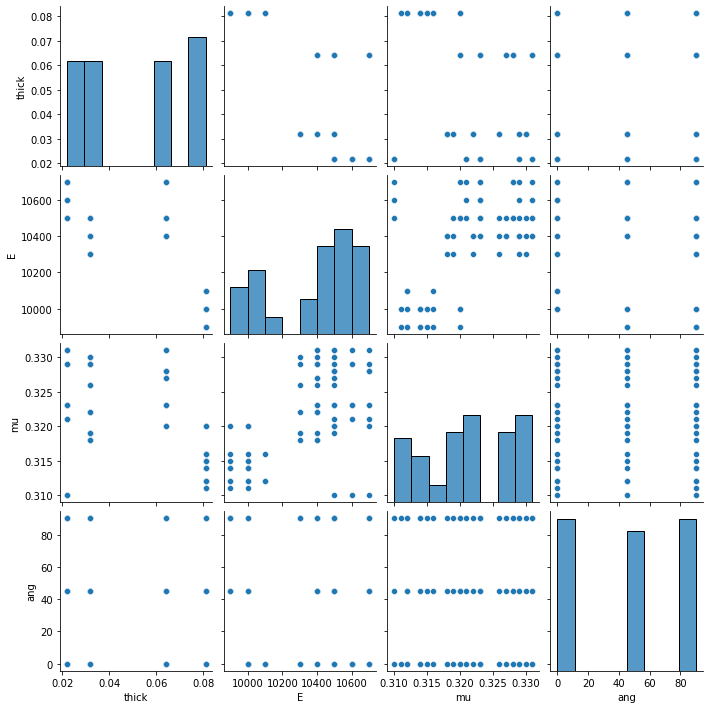

In [5]:
###
# TASK: Visualize the data
# TODO: Use the seaborn function sns.pairplot()
#       to visualize the data.
# NOTE: Remember that Shift + Tab will access
#       the documentation of a function at the
#       cursor.
###

# -- NO NEED TO MODIFY THIS CODE ----
from grama.data import df_stang
import seaborn as sns

# task-begin
# TODO: Pass df_stang and visualize
# sns.pairplot(...)
# task-end

# solution-begin
sns.pairplot(data=df_stang)
# solution-end

Seaborn automatically plots all the numerical variables against each other in a [*scatterplot matrix*](https://en.wikipedia.org/wiki/Scatter_plot#Scatter_plot_matrices). This gives us a quick look at the rough marginal shapes of the data, and a sense of the dependence between variables.

Inspecting this pairplot, we can see there is a bulge of *outliers* in (`E, mu`) space. A bit more data exploration reveals a striking pattern:

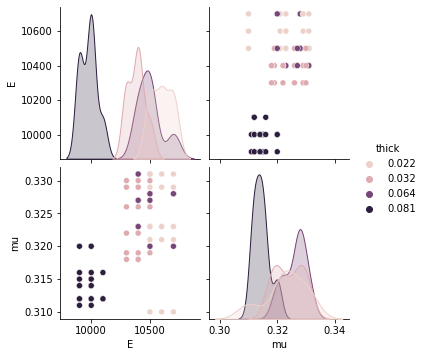

In [6]:
sns.pairplot(df_stang, hue="thick", vars=["E", "mu"])

Observations

- The supplier's plates at `thick == 0.081` have strange behavior! They tend to be less stiff, which could lead to earlier buckling.
- Setting `t` to deterministic in our model essentially assumes independence with `E, mu`. This may not be a valid assumption.
- Note however that the discrepancy is small, relative to the typical elasticity; only about `5%` of the typical value.

In practice, we should do two things:

1. Probe the impact of these data features on our model results. This will tell us whether the feature in the data is *meaningful* for our purposes.
1. Revisit the data; try to determine / understand the cause of this pattern. This step is contingent on findings from the previous step.

To address point (1), we will fit *two* models---one with and one without the thick plates. We will then compare the results to see if this feature in the data appreciably affects our results.

## Fitting a distribution

---

[Skylar's Theorem](https://en.wikipedia.org/wiki/Copula_(probability_theory)#Sklar's_theorem) justifies the modeling of *any* joint distribution in terms of *marginals* and a *copula*. Thus, we will decompose the fitting of a distribution into two steps: first fitting marginals, and then fitting a copula.


### Fitting marginals <a id="s3.2"></a>

The `py_grama` package provides utilities to fit "named" distributions to given data. We will use this simple approach to model the variability observed above. Note that *this approach adds additional information beyond the data*---fitting a distribution *asserts* a shape for the distribution. See the documentation chapter on [Random Variable Modeling](https://py-grama.readthedocs.io/en/latest/source/rv_modeling.html) for more information.

Based on the EDA above, we may choose to fit a normal distribution (`norm`) for `E` and a Beta distribution (`beta`) for `mu`. You will do this in the following exercise.

#### __Q5: Fit marginal distributions__

Building on `md_plate`, fit marginals for `E, mu` based on the filtered and unfiltered Stang et al. data. Compare the fitted parameter values.


In [7]:
###
# TASK: Add marginals
# TODO: Use gr.comp_marginals() to fit marginal distributions for
#       E, mu. Provide two versions of the model; one with the
#       Stang et al. data filtered for thick < 0.08, and one
#       with all the data. Provide these models as md_filtered
#       and md_full, respectively.
#
#       Use the function gr.marg_named() to compute
#       valid marginals for gr.comp_marginals(). Fit a normal ("norm")
#       for `E`, and a Beta ("beta") for `mu`.
#
# NOTE: You will need to pass univariate data to gr.marg_named();
#       You can access a single column "var" of a Pandas DataFrame
#       with either subscript (df.var) or key (df["key"]) notation.
###

# -- NO NEED TO MODIFY THIS CODE ----
# Filter data for the second model
df_filtered = df_stang[df_stang.thick < 0.08]

# task-begin
# TODO: Fit marginals based on the data.
# md_full = ?
# md_filtered = ?
# task-end

# solution-begin
md_full = md_plate >> gr.cp_marginals(
    E=gr.marg_named(df_stang.E, "norm"), mu=gr.marg_named(df_stang.mu, "beta")
)

md_filtered = md_plate >> gr.cp_marginals(
    E=gr.marg_named(df_filtered.E, "norm"),
    mu=gr.marg_named(df_filtered.mu, "beta"),
)
# solution-end

md_filtered.printpretty()
md_full.printpretty()

model: Plate buckling

  inputs:
    var_det:
      w: [6, 18]
      L: (unbounded)
      h: [6, 18]
      t: [0.125, 0.25]

    var_rand:
      E: (+0) norm, {'loc': 10494.444444444445, 'scale': 122.34841969747357}
      mu: (+0) beta, {'a': 6.906673364779303, 'b': 0.6456702700075123, 'loc': 0.2616870498769197, 'scale': 0.06931295012308032}

    copula:
      None

  functions:
      limit state: ['t', 'h', 'w', 'E', 'mu', 'L'] -> ['g_buckle']

model: Plate buckling

  inputs:
    var_det:
      w: [6, 18]
      L: (unbounded)
      h: [6, 18]
      t: [0.125, 0.25]

    var_rand:
      E: (+0) norm, {'loc': 10344.736842105263, 'scale': 258.7392188662194}
      mu: (+0) beta, {'a': 1.0039090847355956, 'b': 0.8622625745559566, 'loc': 0.30940527668994305, 'scale': 0.021594723310056966}

    copula:
      None

  functions:
      limit state: ['t', 'h', 'w', 'E', 'mu', 'L'] -> ['g_buckle']



Note that the marginal parameter values are listed by `printpretty()`; this allows us to see that the location of `E` is largely unchanged, but its `scale` is rather dramatically affected. Changes in the `beta` distribution are more difficult to read from this output; ultimately we will make a judgement in terms of the distribution of function outputs.

However, before we can analyze this model we must define a *copula* structure; if we attempt to perform a Monte Carlo on our model as-defined:

```
gr.eval_sample(md_full, n=100, df_det="nom")
```

we will once again find the error:

```
ValueError:
Present model copula must be defined for sampling.
Use CopulaIndependence only when inputs can be guaranteed
independent. See the Documentation chapter on Random
Variable Modeling for more information.
```

This is because `py_grama` is *explicit* about dependency structures. We will fit a copula with `py_grama` tools below.

### Fitting a copula <a id="s3.3"></a>

A [*copula*](https://en.wikipedia.org/wiki/Copula_(probability_theory)), practically speaking, is a tool to define the dependency structure between random variables. See the [Random Variable Modeling](https://py-grama.readthedocs.io/en/latest/source/rv_modeling.html) documentation chapter for more info. While there are many types of copulas, we will use the simple *Gaussian copula* model below.

#### __Q6: Fit a copula__

Building on `md_filtered` and `md_full`, fit a Gaussian copula for the dependence structure using `gr.comp_copula_gaussian()`.


In [8]:
###
# TASK: Fit a copula
# TODO: Use gr.comp_copula_gaussian() to fit a gaussian copula
#       for both md_filtered and md_full.
###

# task-begin
# TODO: Fit a gaussian copula
# md_filtered = md_filtered >> ...
# md_full = md_full >> ...
# task-end

# solution-begin
md_filtered = md_filtered >> gr.cp_copula_gaussian(df_data=df_filtered)
md_full = md_full >> gr.cp_copula_gaussian(df_data=df_stang)
# solution-end

md_full.printpretty()
md_filtered.printpretty()

model: Plate buckling

  inputs:
    var_det:
      w: [6, 18]
      L: (unbounded)
      h: [6, 18]
      t: [0.125, 0.25]

    var_rand:
      E: (+0) norm, {'loc': 10344.736842105263, 'scale': 258.7392188662194}
      mu: (+0) beta, {'a': 1.0039090847355956, 'b': 0.8622625745559566, 'loc': 0.30940527668994305, 'scale': 0.021594723310056966}

    copula:
      Gaussian copula with correlations:
  var1 var2      corr
0    E   mu  0.371244

  functions:
      limit state: ['t', 'h', 'w', 'E', 'mu', 'L'] -> ['g_buckle']

model: Plate buckling

  inputs:
    var_det:
      w: [6, 18]
      L: (unbounded)
      h: [6, 18]
      t: [0.125, 0.25]

    var_rand:
      E: (+0) norm, {'loc': 10494.444444444445, 'scale': 122.34841969747357}
      mu: (+0) beta, {'a': 6.906673364779303, 'b': 0.6456702700075123, 'loc': 0.2616870498769197, 'scale': 0.06931295012308032}

    copula:
      Gaussian copula with correlations:
  var1 var2      corr
0    E   mu  0.030156

  functions:
      limit state:

You should see that the copula correlation is considerably larger for the full dataset, as compared with the filtered case.

With copulas defined, the grama models are now complete! We finish this tutorial with an illustration of model analysis and comparison.

## Evaluating the model <a id="s4"></a>

---

To conclude this exercise, we illustrate how to evaluate and compare the two models. The following example code constructs histograms for the limit state, drawn from both models' distributions and evaluating each model's function. We will use the nominal input values from `md_ref` as the relevant `df_det` settings for our investigation.

The following code illustrates how to carry out such an analysis.

eval_sample() is rounding n...
eval_sample() is rounding n...


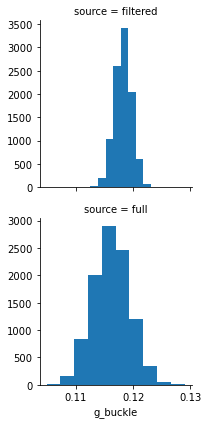

In [9]:
# -- DEMONSTRATION: NO NEED TO MODIFY THIS CODE ----
# Setup
import matplotlib.pyplot as plt

n = 1e4
df_det = md_ref >> gr.ev_nominal(df_det="nom")

# Evaluate models
df_filtered = md_filtered >> gr.ev_sample(n=n, df_det=df_det[md_ref.var_det])
df_filtered["source"] = "filtered"

df_full = md_full >> gr.ev_sample(n=n, df_det=df_det[md_ref.var_det])
df_full["source"] = "full"

## Gather data and plot
df_compare = pd.concat((df_filtered, df_full), axis=0)
g = sns.FacetGrid(df_compare, row="source", sharex=True, sharey=False)
g.map(plt.hist, "g_buckle")

Here we can see that the `filtered` case has a considerably narrower distribution than the `full` case, as we might expect based on the input distribution. We can make a quantitative comparison by summarizing the output values.

In [10]:
# -- DEMONSTRATION: NO NEED TO MODIFY THIS CODE ----
# Quantitative comparison
print("Filtered")
print(df_filtered[md_filtered.out].describe())
print()
print("Full")
print(df_full[md_full.out].describe())

Filtered
           g_buckle
count  10000.000000
mean       0.118206
std        0.001513
min        0.111180
25%        0.117202
50%        0.118225
75%        0.119224
max        0.124409

Full
           g_buckle
count  10000.000000
mean       0.116159
std        0.003172
min        0.104856
25%        0.113998
50%        0.116173
75%        0.118265
max        0.128977


Recall that $g > 0$ corresponds to safe operation. At least at the nominal conditions in which we're interested, both cases are fairly safe. 

### Conclusion

Based on the quantitative results and our stated use-case, the difference between the `filtered` and `full` model cases is negligible. We should be able to use either model for our intended purpose, as we will arrive at similar conclusions.

If we were interested instead in *optimizing* the plate geometry, our conclusion would be very different. Carrying out an uncertainty analysis using the two models above could lead to very different designs, in which case we would need to think more carefully about the difference between the two. Further investigation of the data and manufacturing processes would be necessary to support a more detailed analysis.

# Next Steps
When you are done, please take [this survey](https://docs.google.com/forms/d/e/1FAIpQLSd15FQseSKMxYVSY1dLny0AKXeOPxc6RJVDbwecYALouWHsBQ/viewform?entry.923399158=4088579) about the exercise.

When you're ready, move on to [Tutorial 04: Hierarchical Functions](https://github.com/zdelrosario/py_grama/blob/master/tutorials/t04_dag_assignment.ipynb).


## References

---

[1] David J Peery. Aircraft structures. Courier Corporation, 2011.

[2] Ambrose H. Stang, Martin Greenspan, and Sanford B. Newman, "Poisson's Ratio of Some Structural Alloys for Large Strains" (1946) *Journal of Research of the National Bureau of Standards*
